In [1]:

from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,  inspect

In [2]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [25]:
columns=inspector.get_columns('station')

for column in columns:
    print(column)

{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'longitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'elevation', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}


In [11]:
date=session.query(Measurement.date)
date[-1]

('2017-08-23')

C:\Users\nilay\Anaconda3\lib\site-packages\sqlalchemy\sql\elements.py:4292: SAWarning: Textual SQL expression 'measurement.date >="2016-...' should be explicitly declared as text('measurement.date >="2016-...') (this warning may be suppressed after 10 occurrences)
  {"expr": util.ellipses_string(element)})


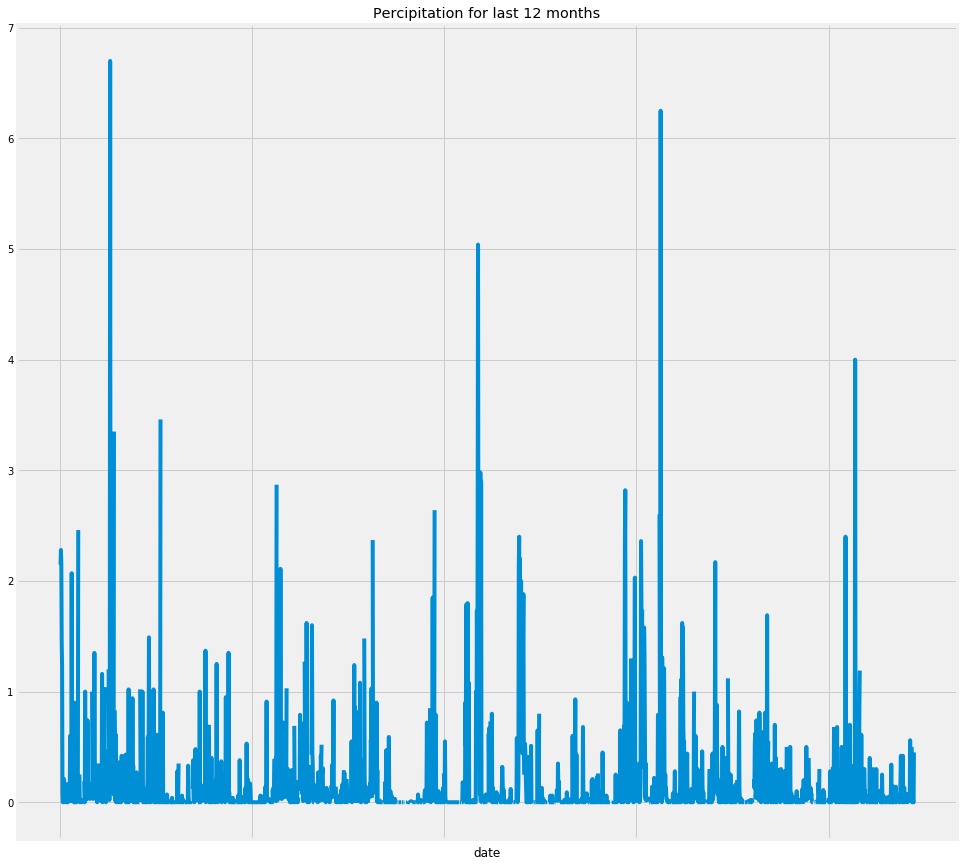

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

percipitation=session.query(Measurement.prcp,Measurement.date,Measurement.station).\
                        filter('measurement.date >="2016-08-24" and measurement.date<="2017-08-23"')


df=pd.DataFrame(percipitation[:]).set_index('date')

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df.sort_values(by='date',ascending=True, inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(y='prcp',title='Percipitation for last 12 months',legend=False, figsize=(15,15))

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
station_count=session.query(Measurement.station).group_by(Measurement.station)

for station in station_count:
    print(station)

('USC00511918',)
('USC00513117',)
('USC00514830',)
('USC00516128',)
('USC00517948',)
('USC00518838',)
('USC00519281',)
('USC00519397',)
('USC00519523',)


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_list=session.query(Measurement.station,func.count(Measurement.tobs)).\
            group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc())

station_df=pd.DataFrame(station_list[:], columns=['station','tobs'])

station_df

,station,tobs
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

min_temp=session.query(func.min(Measurement.tobs)).filter(Measurement.station=='USC00519281')
max_temp=session.query(func.max(Measurement.tobs)).filter(Measurement.station=='USC00519281')
mean_temp=session.query(func.avg(Measurement.tobs)).filter(Measurement.station=='USC00519281')

print("Lowest Temperature Recorded: ", min_temp[0])
print("Highest Temperature Recorded: ", max_temp[0])
print("Average Temperature: ", mean_temp[0])


Lowest Temperature Recorded:  (54.0,)
Highest Temperature Recorded:  (85.0,)
Average Temperature:  (71.66378066378067,)


C:\Users\nilay\Anaconda3\lib\site-packages\sqlalchemy\sql\elements.py:4292: SAWarning: Textual SQL expression 'measurement.date >="2016-...' should be explicitly declared as text('measurement.date >="2016-...') (this warning may be suppressed after 10 occurrences)
  {"expr": util.ellipses_string(element)})


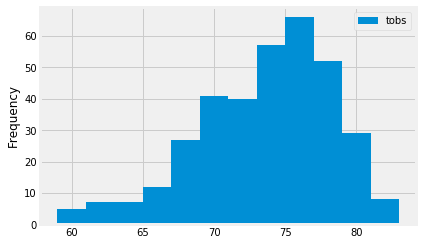

In [10]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature=session.query(Measurement.date,Measurement.tobs).\
                        filter('measurement.date >="2016-08-24" and measurement.date<="2017-08-23" and measurement.station="USC00519281"')
df2=pd.DataFrame(temperature[:])

df2.plot(kind='hist', bins=12)

![precipitation](Images/station-histogram.png)

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps=calc_temps('2017-06-08','2017-06-15')
trip_temps

[(72.0, 77.0576923076923, 83.0)]

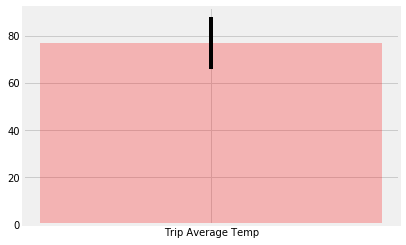

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(x=['Trip Average Temp'],height=[77], yerr=83-72, color='r',alpha=0.25,width=.005,align='center')
plt.title='Trip Average Temp'
plt.ylabel='Temperature (F)'
plt.figsize=(5,1)

In [88]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



prcp_trip=session.query(Measurement.station, Station.name,func.avg(Measurement.prcp), Station.latitude, Station.longitude,Station.elevation).\
             join(Station, Measurement.station==Station.station).filter(Measurement.date >= '2017-06-08').filter(Measurement.date <= '2017-06-15').\
            group_by(Measurement.station).order_by(func.avg(Measurement.prcp).desc())

prcp_trip_df=pd.DataFrame(prcp_trip[:], columns=['station','name','prcp','latitude','longitude','elevation'])

prcp_trip_df

,station,name,prcp,latitude,longitude,elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",0.776667,21.33310,-157.80250,152.4
1,USC00519281,"WAIHEE 837.5, HI US",0.328750,21.45167,-157.84889,32.9
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.205000,21.52130,-157.83740,7.0
3,USC00513117,"KANEOHE 838.1, HI US",0.185000,21.42340,-157.80150,14.6
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.076250,21.33556,-157.71139,19.5
5,USC00519397,"WAIKIKI 717.2, HI US",0.017500,21.27160,-157.81680,3.0
6,USC00517948,"PEARL CITY, HI US",NaN,21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [91]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [107]:
# calculate the daily normals for your trip
days=['06-08','06-09','06-10','06-11','06-12','06-13','06-14','06-15']

min_temp=[]
max_temp=[]
avg_temp=[]

for day in days:
    daily_normal=daily_normals(day)
    min_temp.append(daily_normal[0][0])
    avg_temp.append(daily_normal[0][1])
    max_temp.append(daily_normal[0][2])

[81.0, 81.0, 81.0, 84.0, 83.0, 81.0, 81.0, 81.0]

In [108]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df=pd.DataFrame({'min_temp':min_temp,
                     'avg_temp': avg_temp,
                     'max_temp': max_temp}, index=days)

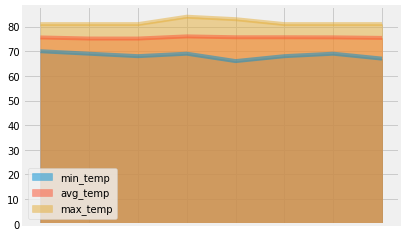

In [116]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot(kind='area', stacked=False)